In [1]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir('C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\data')

# os.listdir()
tmax = 16
T = np.linspace(180,180+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 400
voltage2 = 500

nPoints = 201
master400mv = np.zeros((tmax,nPoints,5))
master500mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
is500 = np.zeros((tmax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master400mv[t,:,0] = tmp1[1:,0]
    master400mv[t,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master400mv[t,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master400mv[t,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master400mv[t,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is400[t,:,0] = ((master400mv[t,:,4]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master400mv[t,:,2]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[t,:,0] = tmp2[1:,0]    
    master500mv[t,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[t,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[t,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[t,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[t,:,0] = ((master500mv[t,:,4]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,1] = ((-master500mv[t,:,2]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,2] = np.sqrt((is500[t,:,0]**2) + (is500[t,:,1]**2))
    is500[t,:,3] = -np.arctan(is500[t,:,1]/is500[t,:,0])*(180/np.pi)
    

# define some simple functions to make the analysis code a bit more concise
def Zr400(T):
    return is400[T,:,0]

def Zr500(T):
    return is500[T,:,0]

def Zi400(T):
    return is400[T,:,1]

def Zi500(T):
    return is500[T,:,1]

def Zmag400(T):
    return is400[T,:,2]

def Zmag500(T):
    return is500[T,:,2]

def phi400(T):
    return is400[T,:,3]

def phi500(T):
    return is500[T,:,3]

def w(T):
    return master400mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = "C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\analysis"

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1



Let's first look at the 400mV data and see what the deal is. Look at the Nyqsuit, Bode, and Re(Z) and Im(Z) plots.

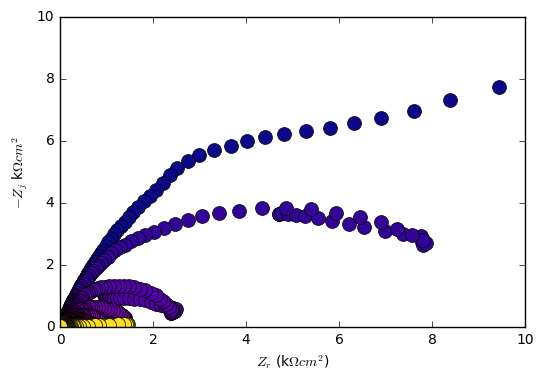

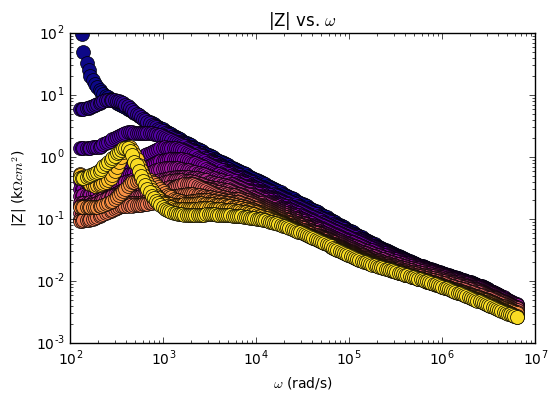

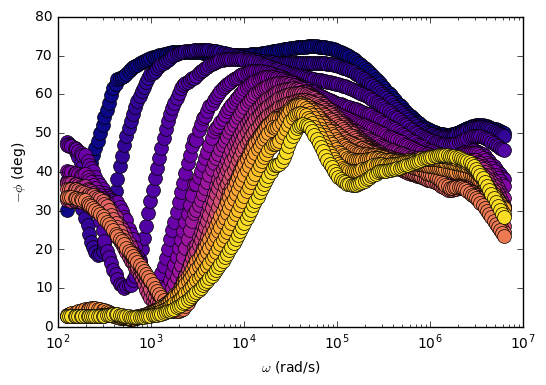

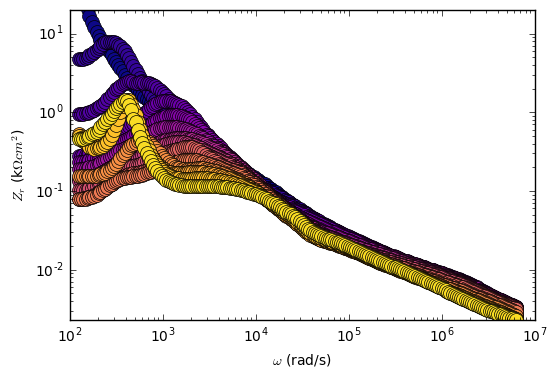

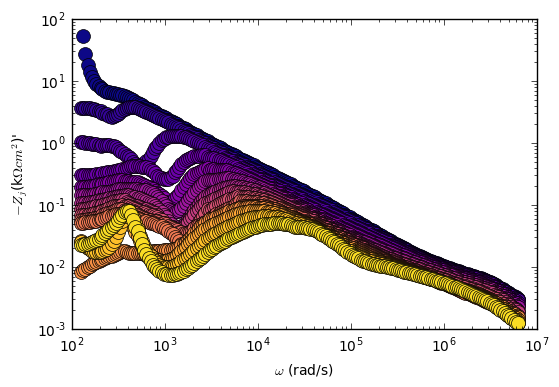

In [3]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(Zr400(t),-Zi400(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,10])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zmag400(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),phi400(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr400(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),abs(-Zi400(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

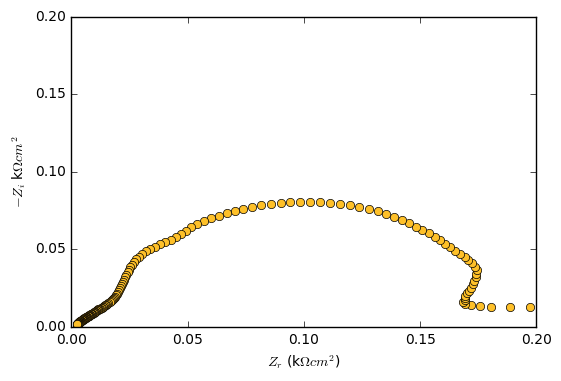

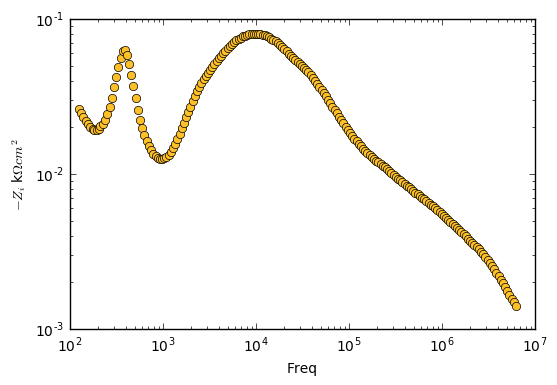

In [4]:
# inspect the plots by temperature to see where we should cut the data off 

tstar = 13

# Nyquist plots
fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(Zr400(tstar),-Zi400(tstar),'o',color = tuple(colSet[tstar]))
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,0.2, 0,0.2])
# plt.savefig('nyquist_all_zoom.png')


fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(w(tstar),abs(-Zi400(tstar)),'o', color = tuple(colSet[tstar]))
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.axis([0,5, 0,1])
# plt.savefig('nyquist_all_zoom.png')

Ok. There is a lot here I don't understand. For instance, we appear to have 2 different relaxation processe with 2 different time constants for many of the temperatures--1 at low $\omega$ and 1 at high $\omega$. We even have 1 at very high $\omega$

The only thing to do is to keep track of both of them. In order to make the comparison to the $CdCl_{2}$ data, my guess is that we want to fit the high $\omega$ arc (not the very high $\omega$ behavior). However, it's probably best to fit both--it's marginally more work, and may prove to be interesting. 

So let's create 2 bounds arrays and use them both in the fit. 

We will fit the high $\omega$ arc from index 2 - index 15. 

We will fit the very high $\omega$ arc from index 13 - index 15. 

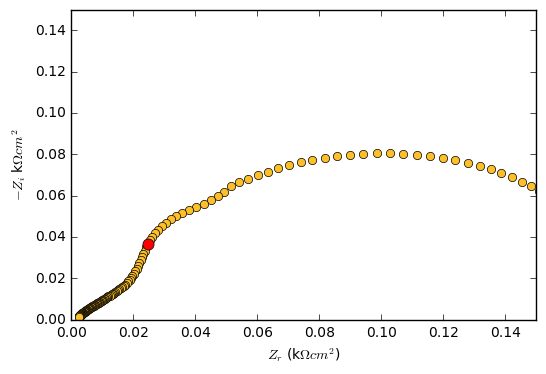

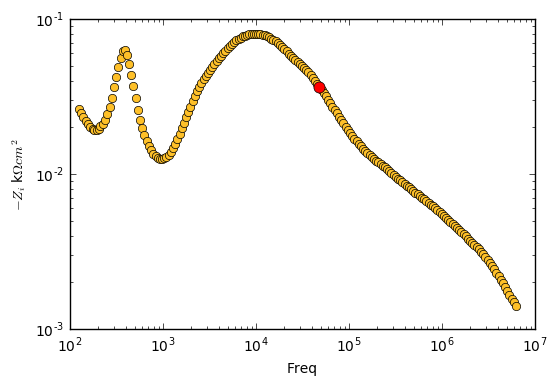

In [5]:
# clumsy way of ID-ing physically reasonable range of fit

bounds1 = np.zeros((16-2)+1)
bounds2 = np.zeros((16-13)+1)


Tt = 13
iguess = 110


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.15, 0,.15])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds1[0] = 19
bounds1[1] = 27
bounds1[2] = 39
bounds1[3] = 42
bounds1[4] = 42
bounds1[5] = 43
bounds1[6] = 44
bounds1[7] = 47
bounds1[8] = 73
bounds1[9] = 67
bounds1[10] = 58
bounds1[11] = 58
bounds1[12] = 58
bounds1[13] = 58

# bounds2[1] = 
# bounds2[2] = 
# bounds2[3] = 
# bounds2[4] = 


Interestingly enough, the *highest* $\omega$ shoulder looks like it comes from the Warburg-y part at low F (diffusion part). That's clearly not an RC arc, and we shouldn't treat it as such.

The other arc looks like it comes out of a little shoulder. For instance, at $T = 310$ K, the shoulder appears at $\omega$ index 110. However, looking at $Im(Z)$ vs. $\omega$ in that neighborhood, the peak doesn't appear well defined. 

So for now let's just fit 1 CPE to this data and see what shakes out. We can always add in features later. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


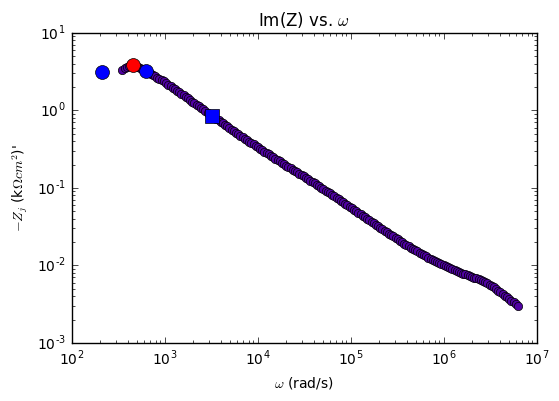

In [6]:
# Extract \alpha from the slope of the Im(z) vs. \omega.

# hardcode the offset above
offSet = 2

# First obtain the bounds by inspection
fig, ax = plt.subplots(1,1)
ax.plot(w(offSet)[bounds1[0]:],abs(-Zi400(offSet)[bounds1[0]:]),'o', color = tuple(colSet[offSet]))
ax.plot(w(offSet)[24],abs(-Zi400(offSet)[24]),'ro',markersize = 10)
ax.plot(w(offSet)[20 + 10],abs(-Zi400(offSet)[20 + 10]),'bo',markersize = 10)
ax.plot(w(offSet)[20 + 40],abs(-Zi400(offSet)[20 + 40]),'bs',markersize = 10)
ax.plot(w(offSet)[20 - 10],abs(-Zi400(offSet)[20 - 10]),'bo',markersize = 10)
# ax.plot(w(5)[20 + 30],abs(-Zi(5)[20 + 30]),'bs',markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# plt.savefig('imZlogLTslope.png')

p1Guess = 24
bAlpha1 = np.array([30, 50])


-0.785024103324 6.24751713345


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


124 0.00199011921663


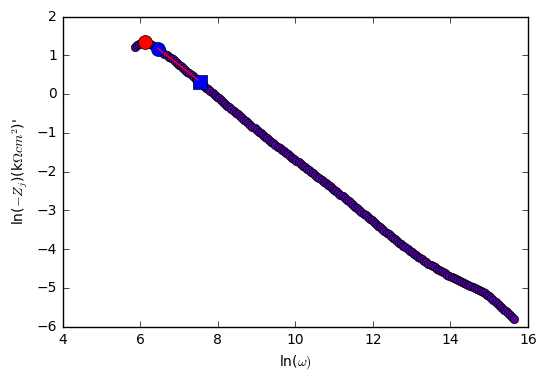

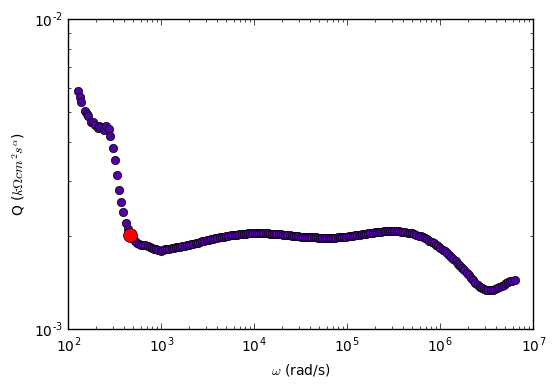

In [244]:
# since the peak appears at such low frequency, let's obtain a guess of \alpha by fitting the positive side of the distribution
x1 = np.vstack( [np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]), np.ones(len(w(offSet)[bAlpha1[0]:bAlpha1[1]]))]).T
y1 = np.log(abs(Zi400(offSet)[bAlpha1[0]:bAlpha1[1]]))
m1,c1 = np.linalg.lstsq(x1,y1)[0]
print(m1,c1)

# First obtain the bounds by inspection
fig, ax = plt.subplots(1,1)
ax.plot(np.log(w(offSet)[bounds1[0]:]),np.log(abs(-Zi400(offSet)[bounds1[0]:])),'o', color = tuple(colSet[offSet]))
ax.plot(np.log(w(offSet)[p1Guess]),np.log(abs(-Zi400(offSet)[p1Guess])),'ro',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[0]]),np.log(abs(-Zi400(offSet)[bAlpha1[0]])),'bo',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[1]]),np.log(abs(-Zi400(offSet)[bAlpha1[1]])),'bs',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]), m1*np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]) + c1, 'r')
ax.set_xlabel("ln($\omega)$")
ax.set_ylabel("ln($-Z_{j}$)(k$\Omega cm^{2}$)'")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# figName = '\\imZlogLTslope.png'
# plt.savefig(figDir + figName,dpi = 300)


# save the slope as the alpha guess. calculate Q_{eff}
alphaG1 = abs(m1)

Qarray = np.sin((alphaG1*np.pi)/2)*(-1/(Zi400(offSet)*w(offSet)**(alphaG1)))

fig, ax = plt.subplots(1,1)
ax.plot(w(offSet)[:],Qarray[:],'o', color= tuple(colSet[offSet]))
ax.plot(w(offSet)[p1Guess],Qarray[p1Guess],'ro', markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("Q ($k \Omega cm^{2} s^{\\alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# ax.set_title("Q vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# plt.savefig('Q_LT.png')
# figName = '\\Q_LT.png'
# plt.savefig(figDir + figName,dpi = 300)


wEff = np.argmax(w(5) > 1e5)
Qguess = Qarray[wEff]
print(wEff,Qguess)


Now we have the following parameter guesses for the lowest tempeature we want to analyze:

1) $\alpha \approx 0.79$

2) $Q_{eff} \approx 1.99\times 10^{-3}k\Omega^{-1} cm^{-2} s^{\alpha}$

Let's now define our fit and plug this in for the initial parameter estimates.

In [227]:
# set up the objective function using the lmfit pacakge. The objective function we are defining in this case are the residuals
# for both the real and imaginary parts of Z. A single array of both real and imaginary residuals is sent to lmfit, which
# then mnimizes the sum of the square of this array.

def circuitModelQ(w,Rs,Rct,Q,alpha):
    return Rs+(Rct/(1+((1j*w)**alpha)*Q*Rct))

def circuitResidQ(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Rs = parvals['Rs']
    Rct = parvals['Rct']
    Q = parvals['Q']
    alpha = parvals['alpha']
    ZrHat = np.real(circuitModelQ(w,Rs,Rct,Q,alpha))
    ZiHat = np.imag(circuitModelQ(w,Rs,Rct,Q,alpha))
    resid1 = ZrHat-Zr
    resid2 = ZiHat-Zi
    return np.concatenate((resid1,resid2))

Parameters([('Rs', <Parameter 'Rs', value=0.072741157773564824 +/- 0.0204, bounds=[0:100]>), ('Rct', <Parameter 'Rct', value=7.3926749045701285 +/- 0.242, bounds=[0:1000.0]>), ('Q', <Parameter 'Q', value=0.00029650646370575352 +/- 3.02e-05, bounds=[0:0.1]>), ('alpha', <Parameter 'alpha', value=0.99999997678779728 +/- 0.0155, bounds=[0:1]>)])


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


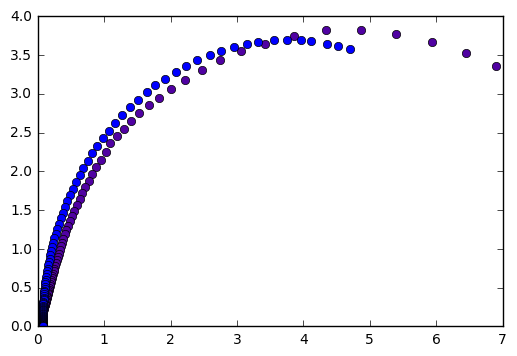

In [265]:
# add paramter estimates to the fit function
params = lmf.Parameters() 
params.add('Rs',value = 1, min = 0, max = 100)
params.add('Rct',value = 1, min = 0, max = 1e3)
params.add('Q',value = Qguess, min = 0, max = 1e-1)
params.add('alpha',value = alphaG1 , min = 0, max = 1)

# empty arrays for storing fit parameters
RsFits = []
RctFits = []
QFits = []
alphaFits =[]

# run the fit
fit = lmf.minimize(circuitResidQ,params,args = (w(offSet)[bounds1[0]:],Zr400(offSet)[bounds1[0]:],Zi400(offSet)[bounds1[0]:]))
RsFits.append(fit.params['Rs'].value)
RctFits.append(fit.params['Rct'].value)
QFits.append(fit.params['Q'].value)
alphaFits.append(fit.params['alpha'].value)
fit.params

print(fit.params)
# plot the resulting fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(offSet)[bounds1[0]:],-Zi400(offSet)[bounds1[0]:],'o',color = tuple(colSet[offSet]))
ax.plot(np.real(RsFits[0]+(RctFits[0]/(1+((1j*w(offSet)[bounds1[0]:])**alphaFits[0])*QFits[0]*RctFits[0]))),-np.imag(RsFits[0]+(RctFits[0]/(1+((1j*w(offSet)[bounds1[0]:])**alphaFits[0])*QFits[0]*RctFits[0]))),'o')     
# ax.set_aspect('equal')
# plt.savefig('nyquistCPEfit.png')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Parameters([('Rs', <Parameter 'Rs', value=0.030012269970367822 +/- 0.00863, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=2.4497576505091989 +/- 0.0479, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00029071620287817438 +/- 2.87e-05, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.99999999268397533 +/- 0.0128, bounds=[0:1]>)])
1
3
Parameters([('Rs', <Parameter 'Rs', value=0.028677568354399385 +/- 0.00566, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=1.3003901655854744 +/- 0.0295, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00027981922392574286 +/- 3.52e-05, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.9999999999734237 +/- 0.000856, bounds=[0:1]>)])
2
4
Parameters([('Rs', <Parameter 'Rs', value=0.023633493665671246 +/- 0.00376, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=0.83092641376050214 +/- 0.0168, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00031007810412279625 +/- 3.86e-05, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.99999998

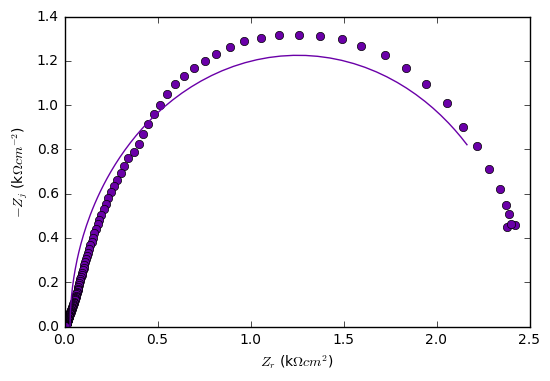

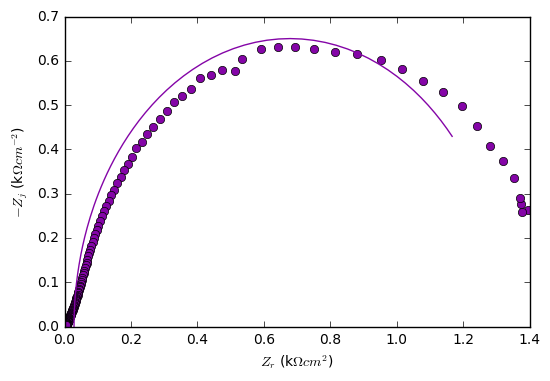

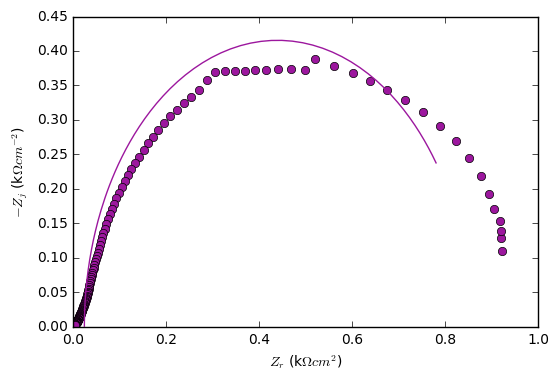

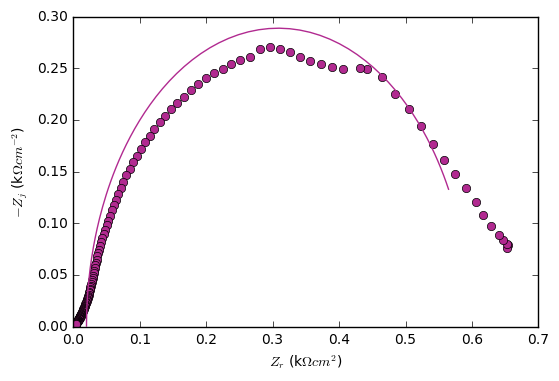

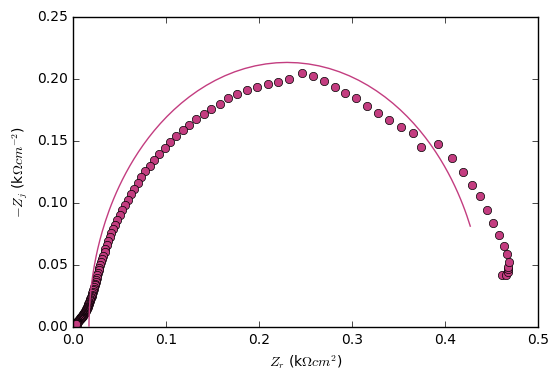

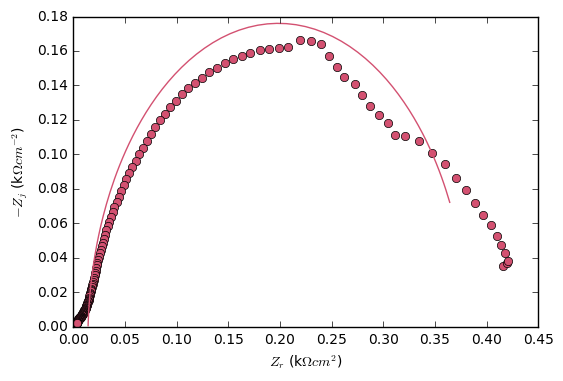

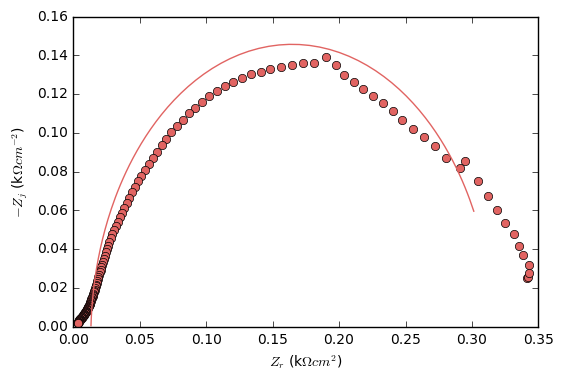

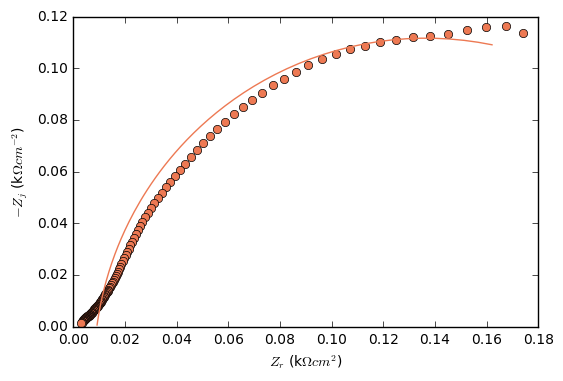

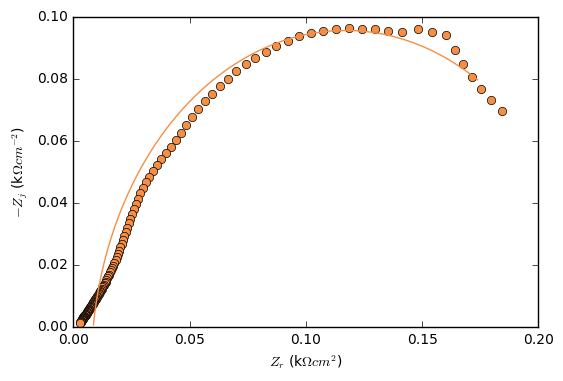

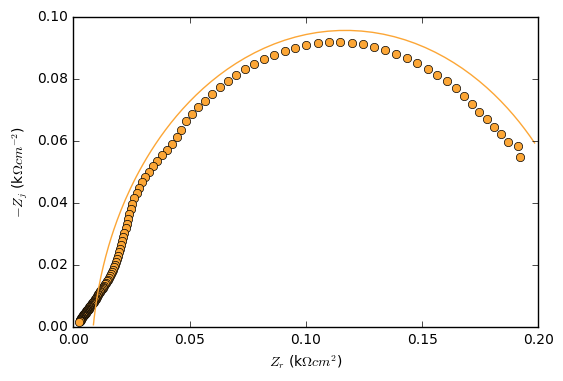

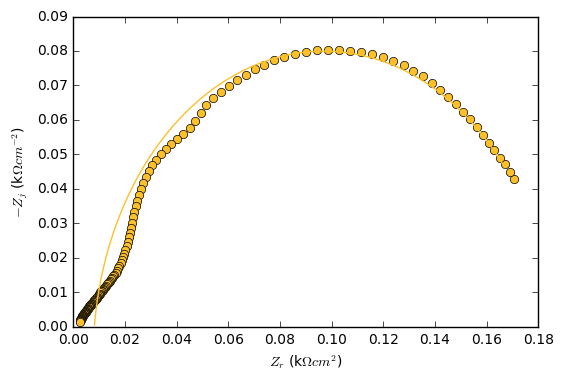

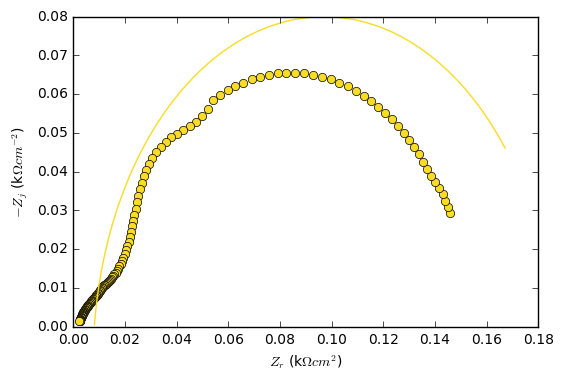

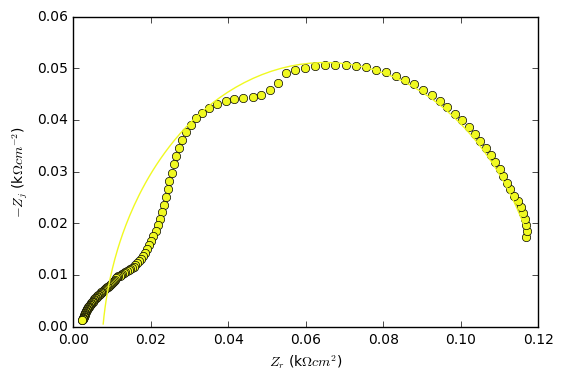

In [266]:
# run the next fit in a loop

for t in range(1,bounds1.shape[0]-1):
# for t in range(1,5):
    params = lmf.Parameters() 
    params.add('Rs',value = RsFits[t-1], min = 0, max = 5)
    params.add('Rct',value = RctFits[t-1], min = 0, max = 100)
    params.add('Q',value = QFits[t-1], min = 0, max = 1e-3)
    params.add('alpha',value = alphaFits[t-1] , min = 0, max = 1)

    # run the fit
    fit = lmf.minimize(circuitResidQ,params,args = (w(t+offSet)[bounds1[t]:],Zr400(t+offSet)[bounds1[t]:],Zi400(t+offSet)[bounds1[t]:]))
    RsFits.append(fit.params['Rs'].value)
    RctFits.append(fit.params['Rct'].value)
    QFits.append(fit.params['Q'].value)
    alphaFits.append(fit.params['alpha'].value)
    fit.params

    print(fit.params)
    print(t)
    print(t+offSet)
    # plot the resulting fit
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr400(t+offSet)[bounds1[t]:],-Zi400(t+offSet)[bounds1[t]:],'o',color = tuple(colSet[t+offSet]))
    ax.plot(np.real(RsFits[t]+(RctFits[t]/(1+((1j*w(t+offSet)[bounds1[t]:])**alphaFits[t])*QFits[t]*RctFits[t]))),-np.imag(RsFits[t]+(RctFits[t]/(1+((1j*w(t+offSet)[bounds1[t]:])**alphaFits[t])*QFits[t]*RctFits[t]))),color = tuple(colSet[t+offSet]))     
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{-2}$)")    
    figName = '\\nyquist_fit_'+ np.array2string(T[t+offSet].astype(int)) + '.png'
    plt.savefig(figDir + figName,dpi = 300)
    